<a href="https://colab.research.google.com/github/rahiakela/computer-vision-case-studies/blob/master/object-detections/object-detection-for-dummies/part_1_gradient_vector_HOG_and_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Gradient Vector, HOG, and SS

> In this series of posts on “Object Detection for Dummies”, we will go through several basic concepts, algorithms, and popular deep learning models for image processing and objection detection. Hopefully, it would be a good read for people with no experience in this field but want to learn more. The Part 1 introduces the concept of Gradient Vectors, the HOG (Histogram of Oriented Gradients) algorithm, and Selective Search for image segmentation.

I’ve never worked in the field of computer vision and has no idea how the magic could work when an autonomous car is configured to tell apart a stop sign from a pedestrian in a red hat. To motivate myself to look into the maths behind object recognition and detection algorithms, I’m writing a few posts on this topic “Object Detection for Dummies”. This post, part 1, starts with super rudimentary concepts in image processing and a few methods for image segmentation. Nothing related to deep neural networks yet. Deep learning models for object detection and recognition will be discussed in [Part 2](https://lilianweng.github.io/lil-log/2017/12/15/object-recognition-for-dummies-part-2.html) and [Part 3](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html).

> **Disclaimer**: When I started, I was using “object recognition” and “object detection” interchangeably. I don’t think they are the same: the former is more about telling whether an object exists in an image while the latter needs to spot where the object is. However, they are highly related and many object recognition algorithms lay the foundation for detection.

Links to all the posts in the series: [[Part 1](https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html)] [[Part 2](https://lilianweng.github.io/lil-log/2017/12/15/object-recognition-for-dummies-part-2.html)] [[Part 3]((https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html))] [[Part 4](https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html)].

## Outline

- Image Gradient Vector
 - Common Image Processing Kernels
 - Example: Manu in 2004
- Histogram of Oriented Gradients (HOG)
 - How HOG works
 - Example: Manu in 2004
- Image Segmentation (Felzenszwalb’s Algorithm)
 - Graph Construction
 - Key Concepts
 - How Image Segmentation Works
 - Example: Manu in 2013
- Selective Search
 - How Selective Search Works
 - Configuration Variations
- References-

## Image Gradient Vector

First of all, I would like to make sure we can distinguish the following terms. They are very similar, closely related, but not exactly the same.


<img src="https://raw.githubusercontent.com/rahiakela/img-repo/master/gradient-vector-table.png" width="width" height="height" style="width:800px;height:300px;"/>

In the image processing, we want to know the direction of colors changing from one extreme to the other (i.e. black to white on a grayscale image). Therefore, we want to measure “gradient” on pixels of colors. The gradient on an image is discrete because each pixel is independent and cannot be further split.

[The image gradient vector](https://en.wikipedia.org/wiki/Image_gradient) is defined as a metric for every individual pixel, containing the pixel color changes in both x-axis and y-axis. The definition is aligned with the gradient of a continuous multi-variable function, which is a vector of partial derivatives of all the variables. Suppose f(x, y) records the color of the pixel at location (x, y), the gradient vector of the pixel (x, y) is defined as follows:

$$ \begin{align*}
\nabla f(x, y)
= \begin{bmatrix}
  g_x \\
  g_y
\end{bmatrix}
= \begin{bmatrix}
  \frac{\partial f}{\partial x} \\[6pt]
  \frac{\partial f}{\partial y}
\end{bmatrix}
= \begin{bmatrix}
  f(x+1, y) - f(x-1, y)\\
  f(x, y+1) - f(x, y-1)
\end{bmatrix}
\end{align*} $$

The $\frac{\partial f}{\partial x}$ term is the partial derivative on the x-direction, which is computed as the color difference between the adjacent pixels on the left and right of the target, $f(x+1, y) - f(x-1, y)$. Similarly, the $\frac{\partial f}{\partial y}$ term is the partial derivative on the y-direction, measured as $f(x, y+1) - f(x, y-1)$, the color difference between the adjacent pixels above and below the target.

There are two important attributes of an image gradient:

- **Magnitude** is the L2-norm of the vector, $g = \sqrt{ g_x^2 + g_y^2 }$
- **Direction** is the arctangent of the ratio between the partial derivatives on two directions, $\theta = \arctan{(g_y / g_x)}$

<img src="https://raw.githubusercontent.com/rahiakela/img-repo/master/image-gradient-vector-pixel-location.png" width="width" height="height" style="width:800px;height:300px;"/>

Fig. 1. To compute the gradient vector of a target pixel at location (x, y), we need to know the colors of its four neighbors (or eight surrounding pixels depending on the kernel).

The gradient vector of the example in Fig. 1. is:

$$
\begin{align*}
\nabla f 
= \begin{bmatrix}
  f(x+1, y) - f(x-1, y)\\
  f(x, y+1) - f(x, y-1)
\end{bmatrix}
= \begin{bmatrix}
  55-105\\
  90-40
\end{bmatrix}
= \begin{bmatrix}
  -50\\
  50
\end{bmatrix}
\end{align*}
$$

Thus,

- the magnitude is $\sqrt{50^2 + (-50)^2} = 70.7107$, and
- the direction is $\arctan{(-50/50)} = -45^{\circ}$

**Repeating the gradient computation process for every pixel iteratively is too slow. Instead, it can be well translated into applying a convolution operator on the entire image matrix, labeled as $\mathbf{A}$ using one of the specially designed convolutional kernels.**

Let’s start with the x-direction of the example in Fig 1. using the kernel $[−1,0,1]$ sliding over the x-axis; ∗ is the convolution operator:

$$
\begin{align*}
\mathbf{G}_x &= 
[-1, 0, 1] \ast [105, 255, 55] = -105 + 0 + 55 = -50
\end{align*}
$$

Similarly, on the y-direction, we adopt the kernel $[+1, 0, -1]^\top$

$$
\begin{align*}
\mathbf{G}_y &= 
[+1, 0, -1]^\top \ast
\begin{bmatrix}
  90\\
  255\\
  40
\end{bmatrix} 
= 90 + 0 - 40 = 50
\end{align*}
$$

Try this in python:





In [ ]:
%%shell

pip install scipy==1.1.0

In [ ]:
import numpy as np
import scipy.signal as sig
import scipy
import cv2
import matplotlib.pyplot as plt

In [ ]:
data = np.array([
   [0, 105, 0],
   [40, 255, 90],
   [0, 55, 0]              
])

G_x = sig.convolve2d(data, np.array([[-1, 0, 1]]), mode='valid')
G_y = sig.convolve2d(data, np.array([[-1], [0], [1]]), mode='valid')
print('G_x: \n', G_x)
print('G_y: \n', G_y)

G_x: 
 [[  0]
 [-50]
 [  0]]
G_y: 
 [[ 0 50  0]]


These two functions return array($[[0], [-50], [0]]$) and array($[[0, 50, 0]]$) respectively. (Note that in the numpy array representation, 40 is shown in front of 90, so -1 is listed before 1 in the kernel correspondingly.)

### Common Image Processing Kernels

**[Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator)**: Rather than only relying on four directly adjacent neighbors, the Prewitt operator utilizes eight surrounding pixels for smoother results.

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-1 & 0 & +1 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +1 & +1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix} \ast \mathbf{A}
$$

**[Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)**: To emphasize the impact of directly adjacent pixels more, they get assigned with higher weights.

$$
\mathbf{G}_x = \begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix} \ast \mathbf{A} \text{ and }
\mathbf{G}_y = \begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix} \ast \mathbf{A}
$$

Different kernels are created for different goals, such as edge detection, blurring, sharpening and many more. Check [this wiki page](https://en.wikipedia.org/wiki/Kernel_(image_processing)) for more examples and references.

### Example: Manu in 2004

Let’s run a simple experiment on the photo of Manu Ginobili in 2004 [[Download Image](https://lilianweng.github.io/lil-log/assets/data/manu-2004.jpg)] when he still had a lot of hair. For simplicity, the photo is converted to grayscale first. For colored images, we just need to repeat the same process in each color channel respectively.

<img src="https://raw.githubusercontent.com/rahiakela/img-repo/master/manu-2004.png" width="width" height="height" style="width:800px;height:300px;"/>

Fig. 2. Manu Ginobili in 2004 with hair. (Image source: [Manu Ginobili’s bald spot through the years](https://ftw.usatoday.com/2013/05/manu-ginobilis-bald-spot-through-the-years))


In [ ]:
!wget https://lilianweng.github.io/lil-log/assets/data/manu-2004.jpg

--2021-02-09 13:15:20--  https://lilianweng.github.io/lil-log/assets/data/manu-2004.jpg
Resolving lilianweng.github.io (lilianweng.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to lilianweng.github.io (lilianweng.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58363 (57K) [image/jpeg]
Saving to: ‘manu-2004.jpg’

manu-2004.jpg       100%[===================>]  57.00K  --.-KB/s    in 0.01s   

2021-02-09 13:15:20 (5.47 MB/s) - ‘manu-2004.jpg’ saved [58363/58363]



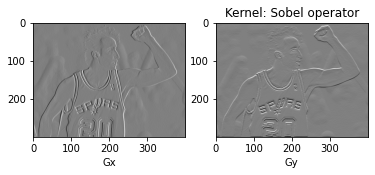

In [ ]:
# With mode="L", we force the image to be parsed in the grayscale, so it is
# actually unnecessary to convert the photo color beforehand.
img = cv2.imread("manu-2004.jpg", 0) # read image as grayscale

# Define the Sobel operator kernels.
kernel_x = np.array([
   [-1, 0, 1],
   [-2, 0, 2],
   [-1, 0, 1]                  
])
kernel_y = np.array([
   [1, 2, 1],
   [0, 0, 0],
   [-1, -2, -1]                  
])

G_x = sig.convolve2d(img, kernel_x, mode="same")
G_y = sig.convolve2d(img, kernel_y, mode="same")

# Plot them!
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Actually plt.imshow() can handle the value scale well even if I don't do 
# the transformation (G_x + 255) / 2.
ax1.imshow((G_x + 255) / 2, cmap='gray'); ax1.set_xlabel("Gx")
ax2.imshow((G_y + 255) / 2, cmap='gray'); ax2.set_xlabel("Gy")
plt.title("Kernel: Sobel operator")
plt.show()

You might notice that most area is in gray. Because the difference between two pixel is between -255 and 255 and we need to convert them back to [0, 255] for the display purpose. A simple linear transformation $(\mathbf{G} + 255)/2$ would interpret all the zeros (i.e., constant colored background shows no change in gradient) as 125 (shown as gray).

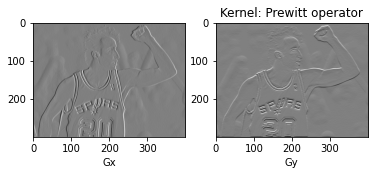

In [ ]:
# Define the Prewitt operator kernels.
kernel_x = np.array([
   [-1, 0, 1],
   [-1, 0, 1],
   [-1, 0, 1]                  
])
kernel_y = np.array([
   [1, 1, 1],
   [0, 0, 0],
   [-1, -1, -1]                  
])

G_x = sig.convolve2d(img, kernel_x, mode="same")
G_y = sig.convolve2d(img, kernel_y, mode="same")

# Plot them!
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Actually plt.imshow() can handle the value scale well even if I don't do 
# the transformation (G_x + 255) / 2.
ax1.imshow((G_x + 255) / 2, cmap='gray'); ax1.set_xlabel("Gx")
ax2.imshow((G_y + 255) / 2, cmap='gray'); ax2.set_xlabel("Gy")
plt.title("Kernel: Prewitt operator")
plt.show()

## Histogram of Oriented Gradients (HOG)

The Histogram of Oriented Gradients (HOG) is an efficient way to extract features out of the pixel colors for building an object recognition classifier. With the knowledge of image gradient vectors, it is not hard to understand how HOG works. Let’s start!

### How HOG works

1. Preprocess the image, including resizing and color normalization.
2. Compute the gradient vector of every pixel, as well as its magnitude and direction.
3. Divide the image into many 8x8 pixel cells. In each cell, the magnitude values of these 64 cells are binned and cumulatively added into 9 buckets of unsigned direction (no sign, so 0-180 degree rather than 0-360 degree; this is a practical choice based on empirical experiments).

For better robustness, if the direction of the gradient vector of a pixel lays between two buckets, its magnitude does not all go into the closer one but proportionally split between two. For example, if a pixel’s gradient vector has magnitude 8 and degree 15, it is between two buckets for degree 0 and 20 and we would assign 2 to bucket 0 and 6 to bucket 20.

This interesting configuration makes the histogram much more stable when small distortion is applied to the image.

<img src="https://raw.githubusercontent.com/rahiakela/img-repo/master/HOG-histogram-creation.png" width="width" height="height" style="width:800px;height:300px;"/>

Fig. 4. How to split one gradient vector’s magnitude if its degress is between two degree bins. (Image source: https://www.learnopencv.com/histogram-of-oriented-gradients/)

4. Then we slide a 2x2 cells (thus 16x16 pixels) block across the image. In each block region, 4 histograms of 4 cells are concatenated into one-dimensional vector of 36 values and then normalized to have an unit weight. The final HOG feature vector is the concatenation of all the block vectors. It can be fed into a classifier like SVM for learning object recognition tasks.



### Example: Manu in 2004

Let’s reuse the same example image in the previous section. Remember that we have computed $\mathbf{G}_x$ and $\mathbf{G}_y$ for the whole image.

In [ ]:
from functools import reduce

In [ ]:
N_BUCKETS = 9
CELL_SIZE = 8  # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.)
    # Handle the case when the direction is between [160, 180)
    right_bin = (int(d / 20.) + 1) % N_BUCKETS
    assert 0 <= left_bin < right_bin < N_BUCKETS

    left_val= m * (right_bin * 20 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val

def get_magnitude_hist_cell(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions = np.abs(np.arctan(cell_y / cell_x) * 180 / np.pi)

    buckets = np.linspace(0, 180, N_BUCKETS + 1)
    bucket_vals = np.zeros(N_BUCKETS)
    map(
        lambda m, d: assign_bucket_vals(m, d, bucket_vals), 
        zip(magnitudes.flatten(), directions.flatten())
    )
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

The following code simply calls the functions to construct a histogram and plot it.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


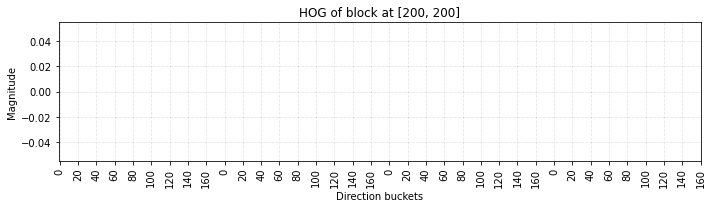

In [ ]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200

ydata = get_magnitude_hist_block(loc_x, loc_y)
ydata = ydata / np.linalg.norm(ydata)

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

The code is mostly for demonstrating the computation process. There are many off-the-shelf libraries with HOG algorithm implemented, such as [OpenCV](https://github.com/opencv/opencv), [SimpleCV](http://simplecv.org/) and [scikit-image](https://scikit-image.org/).

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

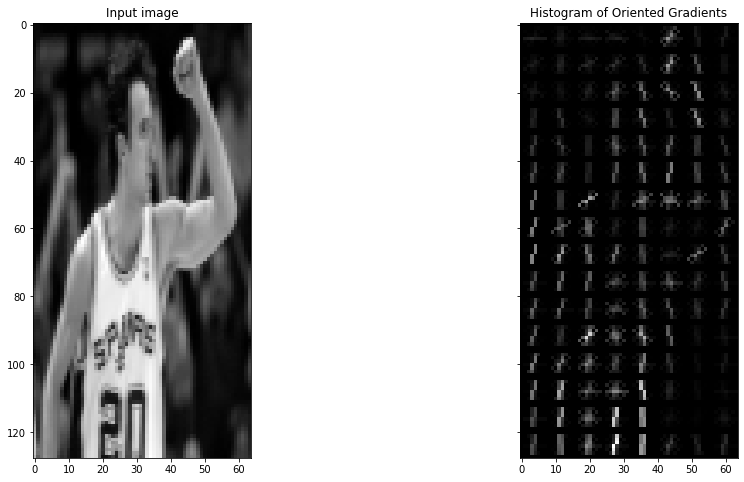

In [ ]:
#resizing image 
resized_img = resize(img, (128,64)) 

#creating hog features 
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

## Image Segmentation (Felzenszwalb’s Algorithm)

When there exist multiple objects in one image (true for almost every real-world photos), we need to identify a region that potentially contains a target object so that the classification can be executed more efficiently.

Felzenszwalb and Huttenlocher ([2004](http://cvcl.mit.edu/SUNSeminar/Felzenszwalb_IJCV04.pdf)) proposed an algorithm for segmenting an image into similar regions using a graph-based approach. It is also the initialization method for Selective Search (a popular region proposal algorithm) that we are gonna discuss later.

Say, we use a undirected graph $G=(V,E)$ to represent an input image. One vertex $v_i \in V$ represents one pixel. One edge $e=(v_i,v_j) \in E$ connects two vertices $v_i$ and $v_j$. Its associated weight $w(v_i,v_j)$ measures the dissimilarity between $v_i$ and $v_j$. The dissimilarity can be quantified in dimensions like color, location, intensity, etc. The higher the weight, the less similar two pixels are. A segmentation solution $S$ is a partition of $V$ into multiple connected components, `{C}`. Intuitively similar pixels should belong to the same components while dissimilar ones are assigned to different components.

### Graph Construction

There are two approaches to constructing a graph out of an image.

- **Grid Graph**: Each pixel is only connected with surrounding neighbours (8 other cells in total). The edge weight is the absolute difference between the intensity values of the pixels.
- **Nearest Neighbor Graph**: Each pixel is a point in the feature space (x, y, r, g, b), in which (x, y) is the pixel location and (r, g, b) is the color values in RGB. The weight is the Euclidean distance between two pixels’ feature vectors.

### Key Concepts

Before we lay down the criteria for a good graph partition (aka image segmentation), let us define a couple of key concepts:

- **Internal difference**: $Int(C)=max_{e \in MST(C,E)}w(e)$, where MST is the minimum spanning tree of the components. A component $C$ can still remain connected even when we have removed all the edges with $weights < Int(C)$.
- **Difference between two components**: $Dif(C_1, C_2)=min_{v_i \in C_1,v_j \in C_2,(v_i,v_j)} \in E^{w(v_i, v_j)}$. $Dif(C_1,C_2)=∞$ if there is no edge in-between.
- **Minimum internal difference:** $MInt(C_1,C_2)=min(Int(C_1)+τ(C_1),Int(C_2)+τ(C_2)), where τ(C)=k/|C|$ helps make sure we have a meaningful threshold for the difference between components. With a higher $k$, it is more likely to result in larger components.

The quality of a segmentation is assessed by a pairwise region comparison predicate defined for given two regions $C_1$ and $C_2$:

$$ D(C_1, C_2) = 
\begin{cases}
  \text{True} & \text{ if } Dif(C_1, C_2) > MInt(C_1, C_2) \\
  \text{False} & \text{ otherwise}
\end{cases} $$

Only when the predicate holds True, we consider them as two independent components; otherwise the segmentation is too fine and they probably should be merged.

### How Image Segmentation Works